In [747]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import integrate
from scipy import signal
from symfit import parameters, variables, sin, cos, Fit
from sympy.core.relational import LessThan as Le
from sympy.core.relational import GreaterThan as Ge
from sympy import Abs
from symfit.core.minimizers import MINPACK,NelderMead,BFGS,Powell,SLSQP

In [760]:
GCM2_CONST = 10000
R = 1.24
peak_distance = 20 # in samples for peak filter
peak_height = 1.2 # in standard deviation for peak filter
nOrder = 60 # order for lowpass filter
FCM = 1/20 # Cutoff Frequency for lowpass noise filter
fitOrder = 3 # fourier order for fitting
FCMX = 1 # Cutoff Frequency for lowpass on fourier coefficient frequencies
FCMN = 1/400 # Cutoff Frequency for highpass on fourier coefficient frequencies
FS_L = [-5,5,FCMN/(2*np.pi),FCMX/(2*np.pi)] # fourier coefficient limits (a&b,frequency in radians)
FS_G = [1.0,2000/(2*np.pi),0,0] #fourier coefficient guesses (a&b,frequency in radians,w,intercept,slope)
SMDF = 1.1 # "decreasing factor" (how much the coefficients should decrease in multiplication - ought to be less than 1 for strict monotonic)

In [761]:
def line(x, *param):
    p = [1,0] # slope, intercept
    p[0:len(param)] = param
    return np.array(x*p[0]+p[1])
def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n` without intercept (at fundamental frequency f).

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    cos_a = parameters(','.join(['a{}'.format(i) for i in range(1, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Add guesses
    for ai in cos_a:
        ai.value = FS_G[0]
    for bi in sin_b:
        bi.value = FS_G[0]
    # Construct the series
    series = sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    # Add constraints
    constraints = []
    for ai in cos_a:
        constraints.append(Ge(ai,FS_L[0]))
        constraints.append(Le(ai,FS_L[1]))
    for bi in sin_b:
        constraints.append(Ge(bi,FS_L[0]))
        constraints.append(Le(bi,FS_L[1]))
    for i in range(n-1):
        ai = cos_a[i]
        ai2 = cos_a[i+1]
        constraints.append(Ge(SMDF*abs(ai),abs(ai2)))
        bi = sin_b[i]
        bi2 = sin_b[i+1]
        constraints.append(Ge(SMDF*abs(bi),abs(bi2)))
    return series,constraints
def fourierModel(xdata,ydata,nFit,Fs):
    
    fourierTransform = np.fft.fft(ydata)/len(ydata)           # Normalize amplitude
    Fs_in = (int(len(ydata)/2))
    fourierTransform = np.abs(fourierTransform[0:int(Fs_in)]) # Exclude sampling frequency
#     plt.plot(fourierTransform)
#     plt.show()
    freq = np.max(fourierTransform)*(Fs/(2*Fs_in))
    print(freq)
    
    x, y = variables('x, y')
    w, intercept, slope = parameters('w, intercept, slope') 
    w.value = FS_G[1]
    intercept.value = FS_G[2]
    slope.value = FS_G[3]
    
    series,constraints = fourier_series(x, f=w, n=nFit)
    constraints.append(Ge(w,FS_L[2]*Fs))
    constraints.append(Le(w,FS_L[3]*Fs))
#     constraints.append(Ge(w,2*np.pi*freq-0.1))
#     constraints.append(Le(w,2*np.pi*freq+0.1))
    model_dict = {y: series + intercept + slope*x}
#     print(constraints)
#     print(model_dict)
    fit = Fit(model=model_dict,constraints = constraints, x=np.array(xdata), y=np.array(ydata),minimizer = [NelderMead,SLSQP])#, minimizer=NelderMead
    fit_result = fit.execute()
    print(fit_result.params)
    fitline = fit.model(x=xdata, **fit_result.params).y
    return fitline,fit_result,fit_result.value(w),fit_result.value(slope),fit_result.value(intercept)
def lpf(x,Fs,Fc):
    return signal.lfilter(signal.firwin(numtaps=nOrder, cutoff=Fc, nyq=Fs/2), 1.0, x)
def linearFit(x,y,nFit,Fs):
    n=len(x)
    fitline,fit_result,w,slope,intercept = fourierModel(x,y,nFit,Fs)
#     peaks,_ = signal.find_peaks(y,height=peak_height*np.std(y),distance = peak_distance)
#     print(peaks)
#     npk = len(peaks)
#     print(npk)
#     if(npk>1):
#         xp = x[peaks]
#         yp = y[peaks]
#         slope = (np.dot(xp,yp)-(1/npk)*(np.sum(xp)*np.sum(yp)))/(np.dot(xp,xp) - (1/npk)*math.pow(np.sum(xp),2))
#     else:
#         print("Error.")
#         n=len(x)
#         slope = (np.dot(x,y)-(1/n)*(np.sum(x)*np.sum(y)))/(np.dot(x,x) - (1/n)*math.pow(np.sum(x),2))
#     intercept = np.median(y) - slope*(x[int(len(x)/2)]-x[0])
#     ###intercept = (np.sum(y)*np.dot(x,x) - np.sum(x)*np.dot(x,y))/(np.dot(x,x)-math.pow(np.sum(x),2))       
    return slope,intercept, fitline
def ac_filter(x,y,Fs):
    slope,intercept,fitline = linearFit(x,y,fitOrder,Fs)
    print(slope," ",intercept)
    return (y - line(x,slope,intercept)),(fitline - line(x,slope,intercept))
def read_tek_tds2000_csv(fname):
    sample_period = 0.0
    raw_samples = []

    with open(fname, 'r') as csvfile:
        c = csv.reader(csvfile)

        # Sample period is in cell B2 (1,1)

        for row_num, row in enumerate(c):
            if row_num == 1: # get the sample period
                sample_period = float(row[1])
                break

        # Sample data starts after the last header line
        # containing the firmware version.
        in_header = True
        for row in c:
            if in_header:
                if row[0] == 'Firmware Version':
                    in_header = False
            else:
                raw_samples.append(float(row[4]))

    return raw_samples, sample_period

In [762]:
def name(i,ch):
    if i < 10 :
        fileint = "0"+str(i)
    else :
        fileint = str(i)
    return "ALL00"+fileint+"/F00"+fileint+"CH"+str(ch+1)+".CSV"

In [763]:
nx = 12
ny = 2
samples = np.zeros(shape = (nx,ny),dtype = object)
data_raw = np.zeros(shape = (nx,ny),dtype = object)
periods = np.zeros(shape = (nx))
for i in range(nx):
    j=0
    sample,period =  read_tek_tds2000_csv(name(i,j))
    sample2,_ =  read_tek_tds2000_csv(name(i,j+1))
    current = -np.array(sample)/R
    flux = GCM2_CONST*integrate.cumtrapz(sample2,period*np.array(range(len(sample))))
    periods[i] = period
    Fs = 1/period
    samples[i] = current,np.array(sample2)
    data_raw[i] = lpf(current[0:len(flux)],Fs,Fs*FCM),lpf(flux,Fs,Fs*FCM)

0.7442439854373819
OrderedDict([('a1', -0.008140966896437401), ('a2', -0.008955063586028768), ('a3', 0.003753004779549028), ('b1', -0.03560281245129678), ('b2', -0.039163093695009484), ('b3', -0.000254161164936189), ('intercept', -0.00467920857293894), ('slope', 0.24042130934201203), ('w', 312.65218829528817)])
0.24042130934201203   -0.00467920857293894
20.744264692915895
OrderedDict([('a1', -0.48438979198075216), ('a2', 0.5328287705818894), ('a3', 0.002789979456945821), ('b1', -0.0866066569130453), ('b2', 0.09526731881820685), ('b3', 0.0677521799597218), ('intercept', -0.9121092963249108), ('slope', -4.188023510713161), ('w', 315.14091248082786)])
-4.188023510713161   -0.9121092963249108


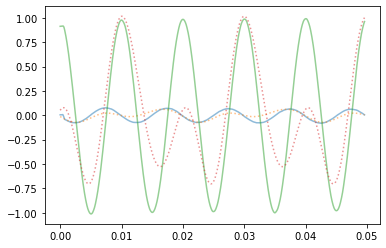

0.45236887867864367
OrderedDict([('a1', -0.009929885826900417), ('a2', -3.75317707150992e-05), ('a3', -4.128494778661237e-05), ('b1', 0.043705477352408574), ('b2', -0.00011439666488843905), ('b3', -0.00012583633137728425), ('intercept', -0.00011774906485796276), ('slope', -0.009963809549656394), ('w', 628.348351498783)])
-0.009963809549656394   -0.00011774906485796276
0.9366378218954164
OrderedDict([('a1', 0.0015941621224705431), ('a2', -0.00019765495795265233), ('a3', 0.00016847752904336548), ('b1', 0.0007739097759505042), ('b2', 5.76071287690203e-05), ('b3', 6.336784164592234e-05), ('intercept', -0.0039000592364926063), ('slope', -1.7185044696717084), ('w', 811.6146368693603)])
-1.7185044696717084   -0.0039000592364926063


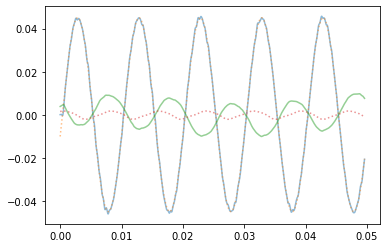

0.4935673680793537
OrderedDict([('a1', -0.010460659723802048), ('a2', 4.478970063848175e-05), ('a3', -4.926867070232993e-05), ('b1', 0.04777413434778), ('b2', 3.0658013264925396e-05), ('b3', -3.372381459141789e-05), ('intercept', -5.9517116942570136e-05), ('slope', -0.010456775061406567), ('w', 628.168071968917)])
-0.010456775061406567   -5.9517116942570136e-05
24.67740475283142
OrderedDict([('a1', -0.9089712001822187), ('a2', -0.9998683202006406), ('a3', -0.02624176956052764), ('b1', 0.08603338945727551), ('b2', 0.09463672840029656), ('b3', -0.10410040124337161), ('intercept', 1.7251216642268135), ('slope', -20.502304532193047), ('w', 312.61637923956323)])
-20.502304532193047   1.7251216642268135


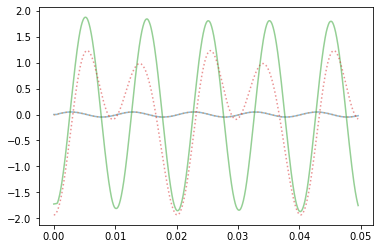

1.2004043985323642
OrderedDict([('a1', 0.08488840588271562), ('a2', -0.0019392388364492382), ('a3', -0.001765657888089939), ('b1', -0.02591812287287916), ('b2', 0.0001329869459046691), ('b3', -9.397677599307468e-05), ('intercept', -0.004596197688052329), ('slope', 0.22494225756043076), ('w', 628.1395600628795)])
0.22494225756043076   -0.004596197688052329
1.3362328341925267
OrderedDict([('a1', -0.02312936663963367), ('a2', -0.01421329430625216), ('a3', -0.01563462373688642), ('b1', -0.010240175427815804), ('b2', 0.011264192970602374), ('b3', 0.012390612267655168), ('intercept', 0.039770615813815365), ('slope', -1.0226833409751312), ('w', 197.39972298797628)])
-1.0226833409751312   0.039770615813815365


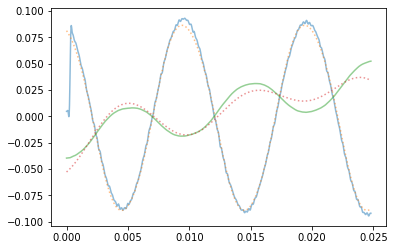

1.8293236330856768
OrderedDict([('a1', 0.014915672464037072), ('a2', -0.016407239710440783), ('a3', -0.0020526304050828325), ('b1', -0.014661744338922244), ('b2', 0.0008421460768998348), ('b3', -0.000926360684589818), ('intercept', 0.018935058111101643), ('slope', -1.641703482739436), ('w', 829.4481695971605)])
-1.641703482739436   0.018935058111101643
0.8210687505353204
OrderedDict([('a1', -0.00040026751791717274), ('a2', -3.276613129586297e-05), ('a3', -1.3431214314012021e-05), ('b1', -0.019621565156708112), ('b2', 0.0004165872712408418), ('b3', -0.00045824599836492597), ('intercept', 0.006980052132103098), ('slope', 1.0810374715364308), ('w', 1254.9522904595221)])
1.0810374715364308   0.006980052132103098


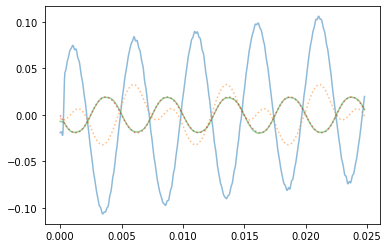

1.1968482730210432
OrderedDict([('a1', -0.012861297146263637), ('a2', -0.014147426860929173), ('a3', 0.009946493537185078), ('b1', -0.07343343793851081), ('b2', -0.08077678173214346), ('b3', 0.038885095639671276), ('intercept', 0.09221480781429804), ('slope', -7.791736659982595), ('w', 252.23387905348548)])
-7.791736659982595   0.09221480781429804
1.0859725875351816
OrderedDict([('a1', -0.019626744102932157), ('a2', 0.00044862666971290133), ('a3', 0.0004934893366841215), ('b1', -3.9764514251055e-05), ('b2', -4.374096567615994e-05), ('b3', -2.000262653250622e-05), ('intercept', 0.018862519524627065), ('slope', 0.6597997984532316), ('w', 629.9658449216873)])
0.6597997984532316   0.018862519524627065


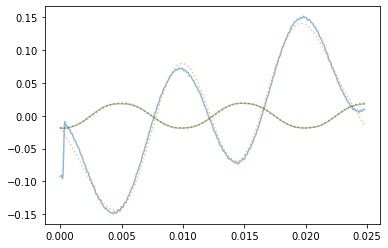

1.522226092239535
OrderedDict([('a1', -0.0021686651362774058), ('a2', -0.0012476226315222196), ('a3', -0.0010573593273507495), ('b1', -0.0170408688678612), ('b2', -0.007797770058379559), ('b3', -0.004665006888136581), ('intercept', 0.047308675127310046), ('slope', -3.465247332750068), ('w', 1005.298828163947)])
-3.465247332750068   0.047308675127310046
0.4433429458753528
OrderedDict([('a1', 0.0014536855958424363), ('a2', 0.001344556811543726), ('a3', 0.0009899797585795303), ('b1', 0.005768579523083593), ('b2', 0.002314243663821194), ('b3', 0.001102909367577184), ('intercept', -0.025093719603195452), ('slope', 1.5661626136806714), ('w', 739.7956652583913)])
1.5661626136806714   -0.025093719603195452


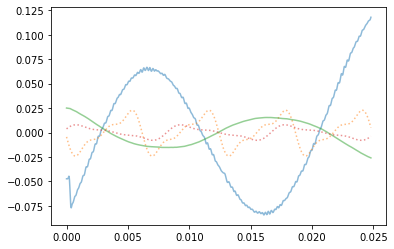

0.3773030419951833
OrderedDict([('a1', -0.0011193076156843641), ('a2', -0.0009934783567827489), ('a3', -0.0009456774793856497), ('b1', -0.005776179610755242), ('b2', -0.002819765150957784), ('b3', -0.0018385133111860723), ('intercept', 0.07155470883889527), ('slope', -1.4595787323172562), ('w', 504.152596597462)])
-1.4595787323172562   0.07155470883889527
0.10862494080017751
OrderedDict([('a1', 0.0003281365651040042), ('a2', 3.6655188772845794e-07), ('a3', -4.0320707650043284e-07), ('b1', 0.0011047899213452639), ('b2', 0.0006071304485092526), ('b3', 0.00028029294264375387), ('intercept', -0.020985722065168185), ('slope', 0.2047055433500334), ('w', 397.2323830727936)])
0.2047055433500334   -0.020985722065168185


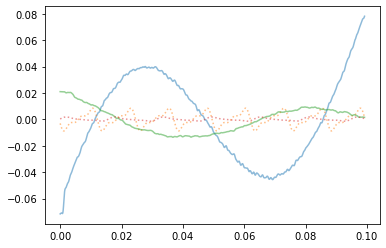

1.0299052739003602
OrderedDict([('a1', -0.0013656453113430798), ('a2', 0.0015022098422230953), ('a3', -0.001652430826659248), ('b1', 0.051183493256589004), ('b2', 0.05630184258246891), ('b3', 0.0003142750984695464), ('intercept', -0.00031588224665231725), ('slope', -0.2968434903606503), ('w', 317.82681163535085)])
-0.2968434903606503   -0.00031588224665231725
0.372165758795656
OrderedDict([('a1', 0.005475152007968684), ('a2', 0.006022667208765849), ('a3', -0.0015745256305192347), ('b1', 0.018807618822490782), ('b2', 0.020688380704743138), ('b3', 9.727245506616245e-05), ('intercept', -0.012871964576462724), ('slope', 0.7623493084398364), ('w', 311.6441349795309)])
0.7623493084398364   -0.012871964576462724


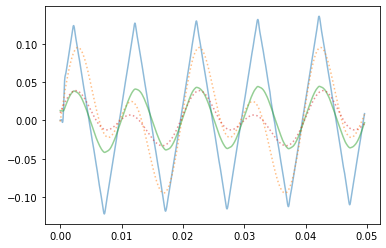

1.4731551146881183
OrderedDict([('a1', 0.0180266675363128), ('a2', 0.019404985718169624), ('a3', 0.02134548440686154), ('b1', -0.04903799879465394), ('b2', -0.05394179873537996), ('b3', 0.059335979136448676), ('intercept', 0.03415074944867559), ('slope', -0.9763299399589973), ('w', 206.78795501194574)])
-0.9763299399589973   0.03415074944867559
0.461503427221337
OrderedDict([('a1', 0.0042933979802590155), ('a2', 0.0011845645628048088), ('a3', -0.0013030210190852693), ('b1', 0.02361508557610417), ('b2', 0.02597659413371444), ('b3', -0.0002116355335426527), ('intercept', -0.01574688840990926), ('slope', 0.5680588125213516), ('w', 314.29734787561614)])
0.5680588125213516   -0.01574688840990926


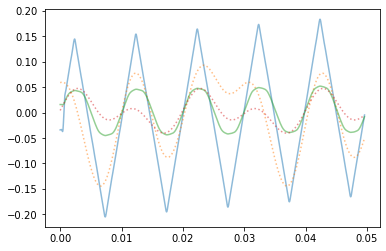

2.941896198076116
OrderedDict([('a1', 0.022891058764253257), ('a2', 0.025180164721902452), ('a3', -0.004243444811709224), ('b1', -0.06634444120565586), ('b2', 0.07297888533614126), ('b3', 4.939228471298623e-05), ('intercept', 0.0198801971208905), ('slope', -1.087516055084986), ('w', 615.0813472136159)])
-1.087516055084986   0.0198801971208905
0.9577792931719101
OrderedDict([('a1', 0.012282706469797936), ('a2', -0.000610499577562587), ('a3', -0.000671549535318844), ('b1', 0.001875635049679478), ('b2', -0.0020631985546479227), ('b3', -0.00013437889531610925), ('intercept', 0.0005083070230205323), ('slope', -0.7743623088386453), ('w', 873.3529064552818)])
-0.7743623088386453   0.0005083070230205323


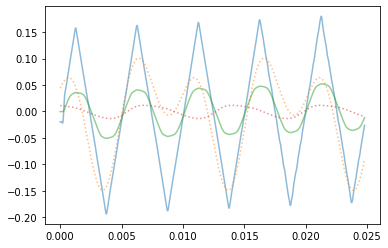

1.4690773629043503
OrderedDict([('a1', 0.01385553484988979), ('a2', 0.0152410883346901), ('a3', 0.01676519716828072), ('b1', 0.02197066612228188), ('b2', -0.02416773273444918), ('b3', 0.02658450600793968), ('intercept', 0.0030416524718811086), ('slope', -0.5494001320543876), ('w', 408.396821883193)])
-0.5494001320543876   0.0030416524718811086
0.5955833812284445
OrderedDict([('a1', 0.006293684259639932), ('a2', 0.006923052685661951), ('a3', 8.993218700466969e-05), ('b1', -0.012586568766568306), ('b2', 0.013845225643255224), ('b3', -0.0008386746926072222), ('intercept', -0.0011967489712791388), ('slope', -0.13791620402382468), ('w', 605.8345887232402)])
-0.13791620402382468   -0.0011967489712791388


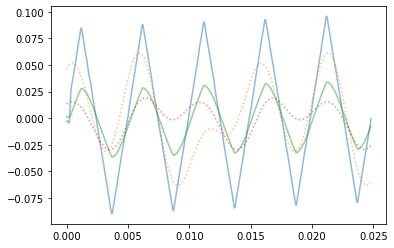

In [764]:
data = np.zeros(shape = (nx,ny),dtype = object)
for i in range(nx):
    for j in range(ny):
    #     print(samples[i,j]
        x = periods[i]*np.array(range(len(data_raw[i,j])))
        y = data_raw[i,j]
        data[i,j],fitline = ac_filter(x,y,1/periods[i])
        plt.plot(x,data[i,j],alpha = 0.5)
        plt.plot(x,fitline,alpha = 0.5,ls=':')
#         print(np.median(data[i,j]))
#         print(linearFit(x,y))
    plt.show()

Frequency = 50000.0 Hz


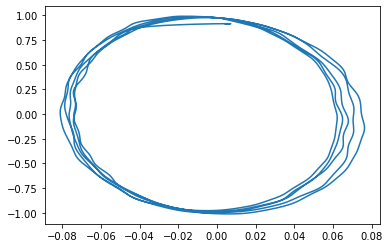

Frequency = 50000.0 Hz


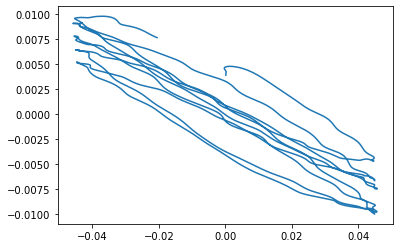

Frequency = 50000.0 Hz


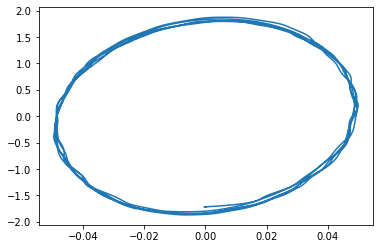

Frequency = 100000.0 Hz


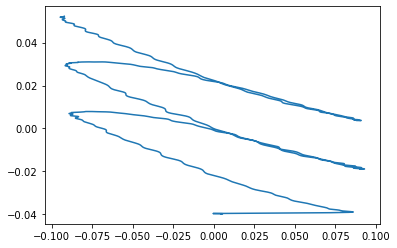

Frequency = 100000.0 Hz


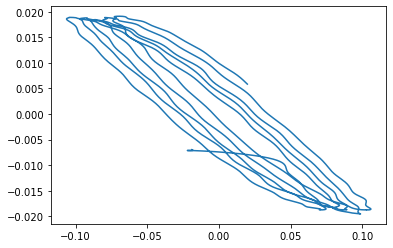

Frequency = 100000.0 Hz


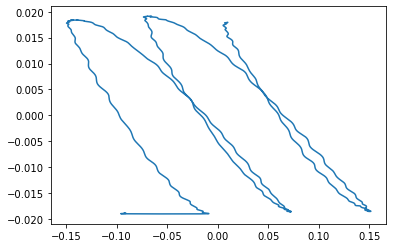

Frequency = 100000.0 Hz


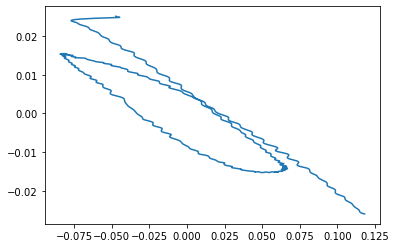

Frequency = 25000.0 Hz


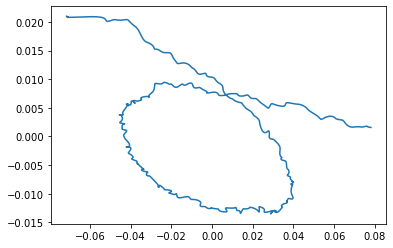

Frequency = 50000.0 Hz


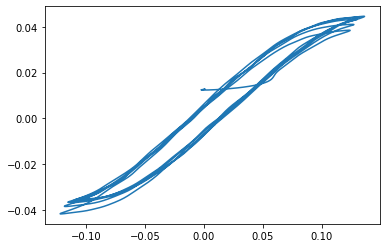

Frequency = 50000.0 Hz


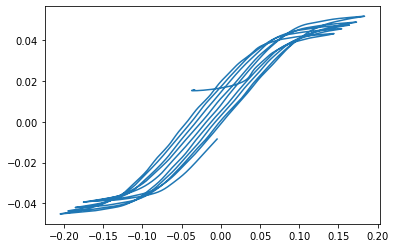

Frequency = 100000.0 Hz


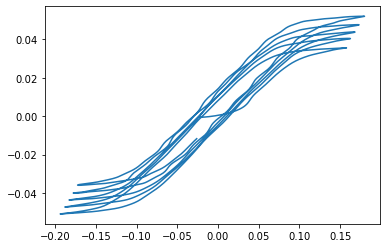

Frequency = 100000.0 Hz


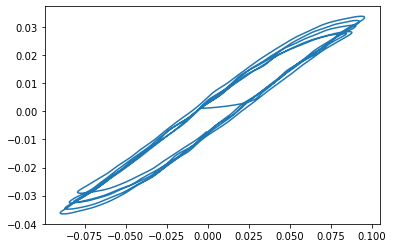

In [765]:
for i in range(nx):
    plt.plot(data[i,0],data[i,1])
    print("Frequency =",round(1/periods[i],4),"Hz")
    plt.show()

C:\Program Files\Python3.8\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Program Files\Python3.8\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


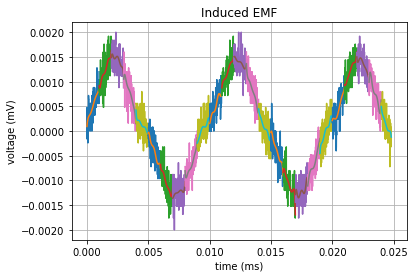

In [81]:
poly = 6
# Raw data before being truncated, in ms and mV #
# EMF response #
x2b = np.array(periods[5]*np.array(range(len(samples[5,1]))))
y2b = np.array(samples[5,1])
# 1.24 Ohm resistor response #
x1b = np.array(periods[5]*np.array(range(len(samples[5,0]))))
y1b = np.array(samples[5,0])



#################################################
###   Plot fitted emf function as mV vs ms    ###
#################################################
fig, ax = plt.subplots()
ax.set(xlabel='time (ms)',
       ylabel='voltage (mV)',
       title='Induced EMF')

ax.grid()
emfFits = []
for n in range(0,x2b.shape[0],100):
    parsx = np.polyfit(x2b[n:n+100],y2b[n:n+100],poly)
    emfFit = np.poly1d(parsx)
    emfFits.append(emfFit)
    plt.plot(x2b[n:n+100],y2b[n:n+100])
    plt.plot(x2b[n:n+100],emfFit(x2b[n:n+100]))

C:\Program Files\Python3.8\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Program Files\Python3.8\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


[0.00487, 0.014700000000000001]


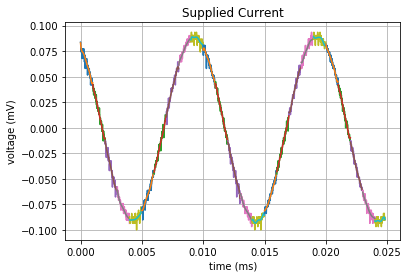

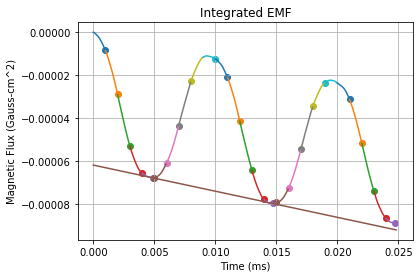

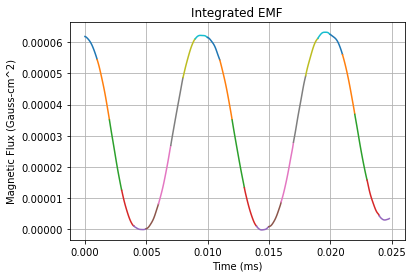

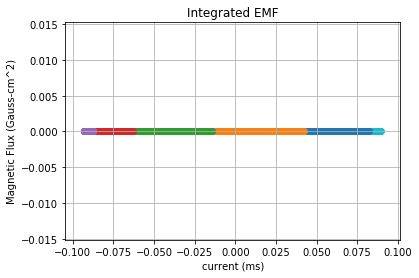

In [84]:
#####################################################
###   Plot fitted current function as mV vs ms    ###
#####################################################
fig, ax = plt.subplots()
ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='Supplied Current')

ax.grid()
currentFits = []
for n in range(0,2500,100):
    parsx = np.polyfit(x1b[n:n+100],y1b[n:n+100],poly)
    currentFit = np.poly1d(parsx)
    currentFits.append(currentFit)

    plt.plot(x1b[n:n+100],y1b[n:n+100])
    plt.plot(x1b[n:n+100],currentFit(x1b[n:n+100]))



#####################################################
###                   Integrate                   ###
#####################################################
temp = []

for emfFit in emfFits:
    # Factor of 100 is conversion to Gauss - cm^2
    emfInt = -np.polyint(emfFit) * 100
    # loops is loops in coil, different based on gap vs pickup.
    loops = 6
    emfInt = emfInt/loops
    temp.append(emfInt)

emfInts = []
for n in range(0,len(temp)):
    xStart = x2b[n * 100]
    emfInts.append(temp[n] - temp[n](xStart))


#####################################################
###          Want all pieces to connect           ###
#####################################################

finalEmfInts = [emfInts[0]]
for n in range(1,len(emfFits)):
    xEnd = x2b[n * 100]
    finalEmfInts.append(emfInts[n] + finalEmfInts[n-1](xEnd))



#####################################################
###      Plot integration as Gauss-cm^2 vs ms     ###
#####################################################
fig, ax = plt.subplots()
ax.set(xlabel='Time (ms)', ylabel='Magnetic Flux (Gauss-cm^2)',
       title='Integrated EMF')

ax.grid()
for n in range(0,len(finalEmfInts)):
    xStart = n * 100
    xEnd = xStart + 100

    plt.plot(x2b[xStart:xEnd], finalEmfInts[n](x2b[xStart:xEnd]))



#####################################################
###              Remove linear offset             ###
#####################################################
# First find minimums of every section
mins = []
minsN = []
for n in range(0,len(finalEmfInts)):
    xStart = n * 100
    xEnd = xStart + 100

    minn = min(finalEmfInts[n](x2b[xStart:xEnd]))
    minnN = np.where(finalEmfInts[n](x2b[xStart:xEnd]) == minn)[0] + xStart
    mins.append(minn)
    minsN.append(x2b[minnN])
    plt.scatter(x2b[minnN],minn)

# Need to find relevant minima

relMin = []
relMinN = []
for n in range(1,len(mins)-1):
    if mins[n] < mins[n-1] and mins[n] < mins[n+1]:
        relMin.append(mins[n])
        relMinN.append(float(minsN[n]))
print(str(relMinN))
linear = np.polyfit(relMinN,relMin,1)
linear = np.poly1d(linear)
plt.plot(x2b, linear(x2b))

fixedEmfInts = []
for emfInt in finalEmfInts:
    fixedEmfInts.append(emfInt - linear)



#####################################################
###      Plot integration as Gauss-cm^2 vs ms     ###
#####################################################
fig, ax = plt.subplots()
ax.set(xlabel='Time (ms)', ylabel='Magnetic Flux (Gauss-cm^2)',
       title='Integrated EMF')

ax.grid()
for n in range(0,len(finalEmfInts)):
    xStart = n * 100
    xEnd = xStart + 100

    plt.plot(x2b[xStart:xEnd], fixedEmfInts[n](x2b[xStart:xEnd]))



#####################################################
###     Plot integration as Gauss-cm^2 vs mA      ###
#####################################################
fig, ax = plt.subplots()
ax.set(xlabel='current (ms)', ylabel='Magnetic Flux (Gauss-cm^2)',
       title='Integrated EMF')

ax.grid()
for n in range(0,len(fixedEmfInts)):
    xStart = n * 100
    xEnd = xStart + 100

    plt.scatter(currentFits[n](x2b[xStart:xEnd]), fixedEmfInts[n](x2b[xStart:xEnd]))
plt.show()